# Object Detection

План на сегодня:
1. Object detection: постановка задачи, метрики
2. Reminder: two-stage vs single-stage detectors
3. Обработка предсказаний: non-max suppression
4. PascalVOC: готовим датасет для обучения
5. $^*$Обучаем детектор

<img src="https://research.aimultiple.com/wp-content/webp-express/webp-images/uploads/2022/01/semantic-segmentation-2.png.webp" style="background:white" width="800"/>

In [ ]:
! pip install pycocotools==2.0.7

### 1. Метрики

#### Intersection over Union (IoU)

<img src="https://habrastorage.org/r/w1560/webt/hg/xi/zj/hgxizjtbx6vlispj9rl8nzfvhsu.png" style="background:white" width="600"/>

In [1]:
import torch
from torchmetrics.detection import IntersectionOverUnion
preds = [
   {
       "boxes": torch.tensor([
            [296.55, 93.96, 314.97, 152.79],
            [298.55, 98.96, 314.97, 151.79]]),
       "labels": torch.tensor([4, 5]),
   }
]
target = [
   {
       "boxes": torch.tensor([
              [300.00, 100.00, 315.00, 150.00],
              [300.00, 100.00, 315.00, 150.00]
       ]),
       "labels": torch.tensor([4, 5]),
   }
]
metric = IntersectionOverUnion(class_metrics=True)
metric(preds, target)


{'iou': tensor(0.7756), 'iou/cl_4': tensor(0.6898), 'iou/cl_5': tensor(0.8614)}

Есть другие варианты, почитайте о них в документации:
- `DistanceIntersectionOverUnion`
- `CompleteIntersectionOverUnion`
- `GeneralizedIntersectionOverUnion`

#### Mean Average Precision (mAP)

$mAP = \sum_i \text{AP}_i$

$AP_i$ - average precision для класса $i$ (площадь под precision-recall кривой)

$
\text{Precision} = \frac{\text{True positive}}{\text{Predicted positive}}
\quad
\text{Recall} = \frac{\text{True positive}}{\text{Total positive}}
$

<img src="https://learnopencv.com/wp-content/uploads/2022/08/mean-average-precision-map-birds-prediction-types.jpg" style="background:white" width="800"/>


Схема расчёта average precision подробнее:

1. Размечаем все предсказания на True Positive и False Positive


<img src="https://learnopencv.com/wp-content/uploads/2022/08/mean-average-precision-map-confidence-scores.png" style="background:white" width="800"/>


2. Ранжируем по убыванию confidence score, считаем precision и recall накопленным итогом
3. Оцениваем среднее значение precision по интерполированным значениям precision-recall кривой

<img src="https://learnopencv.com/wp-content/uploads/2022/08/mean-average-precision-map-calculation-11-point-interpolation-pascal-voc-manual.gif" style="background:white" width="800"/>



In [2]:
from torchmetrics.detection import MeanAveragePrecision
preds = [
  dict(
    boxes=torch.tensor([[258.0, 41.0, 606.0, 285.0]]),
    scores=torch.tensor([0.536]),
    labels=torch.tensor([0]),
  )
]
target = [
  dict(
    boxes=torch.tensor([[214.0, 41.0, 562.0, 285.0]]),
    labels=torch.tensor([0]),
  )
]
metric = MeanAveragePrecision(iou_type="bbox")
metric.update(preds, target)
from pprint import pprint
pprint(metric.compute())

{'classes': tensor(0, dtype=torch.int32),
 'map': tensor(0.6000),
 'map_50': tensor(1.),
 'map_75': tensor(1.),
 'map_large': tensor(0.6000),
 'map_medium': tensor(-1.),
 'map_per_class': tensor(-1.),
 'map_small': tensor(-1.),
 'mar_1': tensor(0.6000),
 'mar_10': tensor(0.6000),
 'mar_100': tensor(0.6000),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.6000),
 'mar_medium': tensor(-1.),
 'mar_small': tensor(-1.)}


### 2. Основные архитектуры

<img src="https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/60d31e388536752a275673aa_machine-learning-infographic.jpg" style="background:white" width="600"/>

<table style="width:100%; table-layout:flex;">
  <tr>
    <td><img height="300px" src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-24_at_5.10.31_PM.png"></td>
    <td><img height="300px" src="https://www.dlology.com/static/media/uploads/yolo/grid_cell_output.jpg"></td>
  </tr>
  <tr>
    <td>Faster RCNN</td>
    <td>YOLO</td>
  </tr>
</table>

На практике предсказания модели будут выглядеть как-то так:

<img src="https://media5.datahacker.rs/2018/11/non_max_b_boxes.png" style="background:white" width="400"/>

**Упражнение**: предложите алгоритм, который уберёт лишние рамки

### 3. Работа с предобученными моделями из `torchvision`

Загрузим изображение для примера:

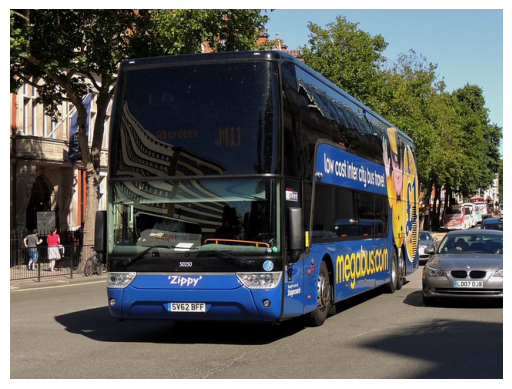

In [3]:
import requests
import matplotlib.pyplot as plt
from PIL import Image

IMAGE_URL = "https://farm4.staticflickr.com/3805/9689301510_83d0cb76c8_z.jpg"

img = Image.open(requests.get(IMAGE_URL, stream=True).raw)

plt.imshow(img)
plt.axis(False)
plt.show()

Создадим детектор SSD с весами после обучения на датасете COCO (Common Objects in COntext), получим предсказания для нашего изображения:

In [4]:
from torchvision.models.detection import ssdlite320_mobilenet_v3_large, SSDLite320_MobileNet_V3_Large_Weights
weights = SSDLite320_MobileNet_V3_Large_Weights.COCO_V1
ssd = ssdlite320_mobilenet_v3_large(weights=weights)

# переводим модель в eval - для train режима нужна правильная разметка
ssd.eval()

transform = weights.transforms()
classes = weights.meta["categories"]

with torch.no_grad():
    predictions = ssd.forward(transform(img).unsqueeze(0))[0]

print(predictions.keys())

dict_keys(['boxes', 'scores', 'labels'])


In [5]:
for key, value in predictions.items():
    print(f"{key}:", value[:3])

boxes: tensor([[118.6065,  59.4558, 526.4258, 421.0014],
        [531.4886, 278.8501, 640.0000, 383.8829],
        [ 96.6772, 297.6939, 116.1169, 323.3723]])
scores: tensor([0.9983, 0.9812, 0.3076])
labels: tensor([6, 3, 1])


Предсказаний много, давайте ограничимся только самыми уверенными:

In [6]:
mask = predictions["scores"] > 0.2
boxes = predictions['boxes'][mask]
labels = predictions['labels'][mask]
scores = predictions['scores'][mask]

In [7]:
colors_dict = {
    1: "pink",
    3: "orange",
    6: "cyan",
}

assert len(colors_dict) == len(labels.unique()), "Create as many colors as there are unique labels!"

In [8]:
# создадим словарь для цветов рамок в зависимости от класса объекта
# present_classes = sorted(set(labels.tolist()))
# colormap =  plt.colormaps.get_cmap("Set1")
# colors = [
#     tuple(transforms.ConvertImageDtype(torch.uint8)(torch.tensor(colormap(x)[:3])).tolist())
#     for x in torch.linspace(0, 1, len(present_classes))
# ]
# colors_dict = {i: c for i, c in zip(present_classes, colors)}

Отрисуем рамки предсказаний:

(-0.5, 639.5, 479.5, -0.5)

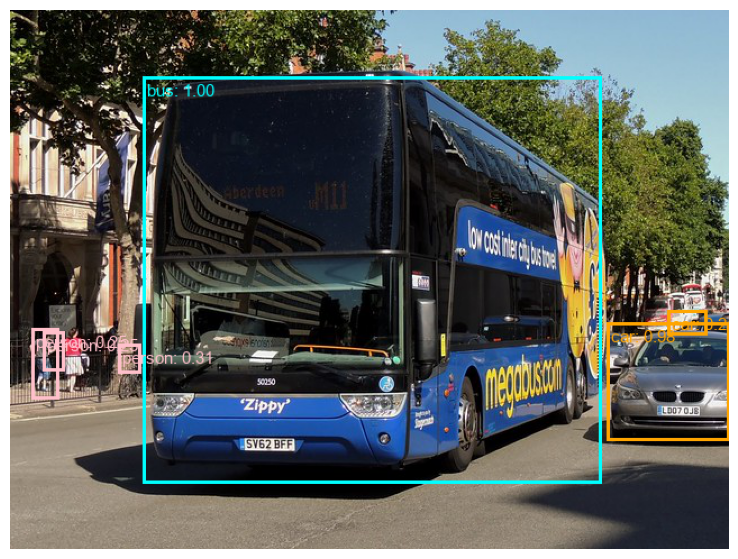

In [9]:
import torchvision
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes

# нарисуем рамки
detection = draw_bounding_boxes(
    transforms.Compose([transforms.ToTensor(), transforms.ConvertImageDtype(torch.uint8)])(img),
    boxes=boxes,
    labels=[f"{classes[int(label)]}: {float(score):.2f}" for label, score in zip(labels, scores)],
    width=3,
    font="Arial",
    font_size=15,
    colors=[colors_dict[ix] for ix in labels.tolist()],
)
detection: Image.Image = torchvision.transforms.ToPILImage()(detection)

fig, ax = plt.subplots(figsize=(10, 7))
ax.imshow(detection)
plt.axis(False)

### 4. Обучение SSD

#### Скачиваем датасет

In [11]:
from torchvision.datasets.voc import VOCDetection
from torchvision import transforms

from torchvision.models.detection import ssdlite320_mobilenet_v3_large, SSDLite320_MobileNet_V3_Large_Weights
weights = SSDLite320_MobileNet_V3_Large_Weights.COCO_V1

root = "/content"

train_dataset = VOCDetection(root, year="2007", image_set="train", download=True, transforms=None)
val_dataset = VOCDetection(root, year="2007", image_set="val", download=True, transforms=None)

Using downloaded and verified file: /Users/sarapulov/Documents/datasets/VOCtrainval_06-Nov-2007.tar
Extracting /Users/sarapulov/Documents/datasets/VOCtrainval_06-Nov-2007.tar to /Users/sarapulov/Documents/datasets/
Using downloaded and verified file: /Users/sarapulov/Documents/datasets/VOCtrainval_06-Nov-2007.tar
Extracting /Users/sarapulov/Documents/datasets/VOCtrainval_06-Nov-2007.tar to /Users/sarapulov/Documents/datasets/


In [12]:
train_dataset[0]

(<PIL.Image.Image image mode=RGB size=500x333>,
 {'annotation': {'folder': 'VOC2007',
   'filename': '000012.jpg',
   'source': {'database': 'The VOC2007 Database',
    'annotation': 'PASCAL VOC2007',
    'image': 'flickr',
    'flickrid': '207539885'},
   'owner': {'flickrid': 'KevBow', 'name': '?'},
   'size': {'width': '500', 'height': '333', 'depth': '3'},
   'segmented': '0',
   'object': [{'name': 'car',
     'pose': 'Rear',
     'truncated': '0',
     'difficult': '0',
     'bndbox': {'xmin': '156', 'ymin': '97', 'xmax': '351', 'ymax': '270'}}]}})

Нам нужно превратить изображение в тензор, а аннотацию в формат, который понимают детекторы из `torchvision`, т.е. словарь такого вида

```python
{
    "boxes": torch.Tensor = ...,
    "labels": torch.Tensor = ...,
}
```

Упражнение:
1. Напишите функцию для преобразования аннотации в нужный формат

In [ ]:
from typing import Any


VOC_CLASSES = [
    "person",
    "bird", "cat", "cow", "dog", "horse", "sheep",
    "aeroplane", "bicycle", "boat", "bus", "car", "motorbike", "train",
    "bottle", "chair", "diningtable", "pottedplant", "sofa", "tvmonitor"
]

def annotation_transform(annotation: dict[str, Any]) -> dict[str, torch.Tensor]:
    return {
        "boxes": ...,
        "labels": ...
    }

2. Создайте трансформацию для изображений, можно взять готовую из весов SSD (`SSDLite320_MobileNet_V3_Large_Weights.COCO_V1.transform`)

In [ ]:
from torchvision.models.detection import ssdlite320_mobilenet_v3_large, SSDLite320_MobileNet_V3_Large_Weights
weights = SSDLite320_MobileNet_V3_Large_Weights.COCO_V1
ssd = ssdlite320_mobilenet_v3_large(weights=weights)
image_transform = weights.transforms()

3. Создайте заново объекты датасетов, передав внутрь нужные трансформации; убедитесь, что датасет возвращает по индексу пару `torch.Tensor, dict[str, torch.Tensor]`

In [ ]:
train_dataset = ...
val_dataset = ...

4. Создайте загрузчики данных, вам потребуется изменить способ упаковки объектов в батчи (т.к. картинки разного размера), для этого используйте аргумент `collate_fn`; убедитесь, что батч - это `tuple[Sequence[Tensor], Sequence[dict[str, Tensor]]]`

In [ ]:
from torch.utils.data import DataLoader

train_loader = ...
images, annotation = next(iter(train_loader))

5. Убедитесь, что метод `forward` в модели теперь работает на наших данных

In [ ]:
preds = ssd.forward(images, annotation)

In [ ]:
preds